# 0. Setup

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import datetime
import random
import os
import statistics as st
from decimal import Decimal as D

import matplotlib.pyplot as plt
import matplotlib as mpl

from lib.Line import Line
from lib.Station import Station
from lib.Platform import Platform
from lib.Passenger import Passenger
from lib.Train import Train
from lib.RailwayNetwork import RailwayNetwork

## Load raw data of passengers

Raw data with the number of in-out passengers per station and time window.

In [2]:
DATA_PATH = '../data/'
PARSED_PATH = DATA_PATH + 'parsed/'
IMAGES_PATH = DATA_PATH + 'images/'

FLOW_IMAGES_PATH = IMAGES_PATH + 'flow/'
INFECTION_IMAGES_PATH = IMAGES_PATH + 'infection/'

os.makedirs(FLOW_IMAGES_PATH, exist_ok=True)
os.makedirs(INFECTION_IMAGES_PATH, exist_ok=True)

In [3]:
connections = pd.read_csv(PARSED_PATH + 'station_connections.csv', index_col=False)
timetable = pd.read_csv(PARSED_PATH + 'timetable.csv', index_col=False)
w_lines = pd.read_csv(PARSED_PATH + 'line_weights.csv', index_col=False)
w_times = pd.read_csv(PARSED_PATH + 'times_weights.csv', index_col=False)
w_stations = pd.read_csv(PARSED_PATH + 'station_weights.csv', index_col=False)
station_coords = pd.read_csv(PARSED_PATH + 'station_coords.csv', index_col=False)

In [4]:
# Transform strings to time objects
timetable['ARRIVAL_TIME'] = pd.to_datetime(timetable['ARRIVAL_TIME'])
timetable['ARRIVAL_TIME'] = [t.time() for t in timetable['ARRIVAL_TIME']]

timetable['DEPARTURE_TIME'] = pd.to_datetime(timetable['DEPARTURE_TIME'])
timetable['DEPARTURE_TIME'] = [t.time() for t in timetable['DEPARTURE_TIME']]

w_times['TIME'] = pd.to_datetime(w_times['TIME'])
w_times['TIME'] = [t.time() for t in w_times['TIME']]
w_times['WEIGHT_IN'] = [D(w) for w in w_times['WEIGHT_IN']]

w_lines['WEIGHT_IN'] = [D(w) for w in w_lines['WEIGHT_IN']]
w_lines['WEIGHT_OUT'] = [D(w) for w in w_lines['WEIGHT_OUT']]

w_stations['TIME'] = pd.to_datetime(w_stations['TIME'])
w_stations['TIME'] = [t.time() for t in w_stations['TIME']]
w_stations['WEIGHT_IN'] = [D(w) for w in w_stations['WEIGHT_IN']]
w_stations['WEIGHT_OUT'] = [D(w) for w in w_stations['WEIGHT_OUT']]

In [5]:
# Cast values
connections = connections.astype({'DIRECTION': 'int32'})
timetable = timetable.astype({'IS_START': 'int32', 'IS_END': 'int32', 'DIRECTION': 'int32'})
station_coords = station_coords.astype({'X': 'float', 'Y': 'float'})

In [6]:
# Set indexes
connections = connections.set_index(['LINE', 'FROM_STATION'])
timetable = timetable.set_index(['LINE', 'STATION_NAME'])
w_lines = w_lines.set_index(['LINE'])
w_times = w_times.set_index(['TIME'])
w_stations = w_stations.set_index(['LINE', 'STATION_NAME', 'TIME'])
station_coords = station_coords.set_index(['STATION_NAME'])

In [7]:
w_stations.head()

WEIGHT_IN  \
LINE STATION_NAME TIME                 
C10  PRINCIPE PIO 00:00:00         0   
                  00:01:00         0   
                  00:02:00         0   
                  00:03:00         0   
                  00:04:00         0   

                                                                   WEIGHT_OUT  
LINE STATION_NAME TIME                                                         
C10  PRINCIPE PIO 00:00:00  0.52994446446603182820922484097536653280258178...  
                  00:01:00  0.52994446446603182820922484097536653280258178...  
                  00:02:00  0.52994446446603182820922484097536653280258178...  
                  00:03:00  0.52994446446603182820922484097536653280258178...  
                  00:04:00  0.52994446446603182820922484097536653280258178...

## Build dictionaries and define functions

In [8]:
station_names = connections.reset_index()['FROM_STATION'].unique()

In [9]:
# Build dictionary: name of stations -> numerical ID
station2id = {st_name:i for i, st_name in enumerate(station_names)}
id2station = {i:st_name for i, st_name in enumerate(station_names)}

In [10]:
# Example of getting a value of a line-station in a specific time
k_time = datetime.time(15, 0) # 15PM
w_stations.loc[('C5', 'ATOCHA', k_time), 'WEIGHT_IN']

Decimal('41.659471990957598563909414224326610565185546875')

In [11]:
def get_cmap(max_scale):
    # Color mapping for nodes
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.5, .5, .5, 1.0) # Force the first color entry to be grey

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    cmap.set_over('#811a17')

    # define the bins and normalize
    bounds = np.linspace(0, max_scale)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    return cmap, norm

# 1. One-day flow simulation

Before we proceed to run an infection simulation, we test how is the flow of passengers.

First we need to initialize the objects of the network:

In [11]:
# Time of service (set to None if it never closes)
open_time = datetime.time(5, 0) # 5AM
close_time = datetime.time(1, 0) # 1AM

n_passengers = 400000

network = RailwayNetwork(n_passengers, open_time, close_time, w_times, w_lines, w_stations, timetable, connections)
stations = {st_name:Station(network, st_name, w_stations) for st_name in station_names}
lines = {line_name:Line(network, line_name, w_lines) for line_name in w_lines.index}

# Once every object is created, add to them to the network and init it
network.init_network(lines, stations, debug=True)

Network is ready!                                                                   


In [13]:
# Sample station weights
s = Station(network, 'FUENLABRADA', w_stations)
print(s.get_weight(line_name='C5'))

(Decimal('18111.99999999999739053180306'), Decimal('16222.99999999999725708299526'))


In [14]:
G = nx.Graph()

G.add_nodes_from(station2id.values())

# Add attributes to nodes
for st_name, node_id in station2id.items():
    pos_x = station_coords.at[st_name, 'X']
    pos_y = station_coords.at[st_name, 'Y']
    G.add_node(node_id, pos=(pos_x, pos_y), station=stations[st_name])

# Add edges
for i, row in connections.iterrows():
    node_from = station2id[i[1]]
    node_to = station2id[row['TO_STATION']]
    
    G.add_edge(node_from, node_to)

In [15]:
max_scale = 150 # Max value in the scale of colors
cmap, norm = get_cmap(max_scale) # Color mapping for nodes

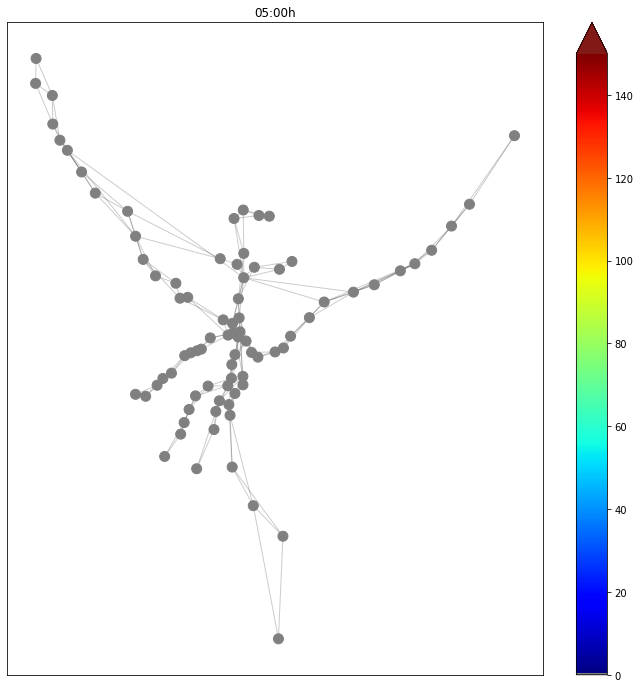

In [16]:
# This section code is just for debug purposes (to see visually the shape of the network)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('%sh' % network.get_time().strftime('%H:%M'))

pos = nx.get_node_attributes(G, 'pos')

colors = [s.get_n_passengers() for node_id, s in nx.get_node_attributes(G, 'station').items()]

ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=colors, 
                            with_labels=False, node_size=100, cmap=cmap, norm=norm, vmax=max_scale)
fig.colorbar(nc, extend='max')

Then we can proceed to run the simulation:

In [17]:
# Display how the number of passengers changes on each station

n_iters = 20 * 60 # 20 hours * 60 minutes

pos = nx.get_node_attributes(G, 'pos')

network.reset()

for i in range(n_iters):
    print('\r%d of %d' % (i + 1, n_iters), ' '*10, end='')
    
    network.step()
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1)
    
    ax.set_title('%sh' % network.get_time().strftime('%H:%M'))

    colors = [s.get_n_passengers() for node_id, s in nx.get_node_attributes(G, 'station').items()]

    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=colors, 
                                with_labels=False, node_size=100, cmap=cmap, norm=norm, vmax=max_scale)
    fig.colorbar(nc, extend='max', ax=ax)
    
    fig.savefig('%s%s.png' % (FLOW_IMAGES_PATH, network.get_time().strftime('%H-%M')))
    plt.close(fig)
    
print('')
print('Simulation finished!', ' '*10)

1200 of 1200           Finish!           


# 2. One-day infection simulation

Based on the results published by Los Alamos National Laboratory (https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article), the value $R_0$ should be around $5.7$. That is, an infected person infects to other $5.7$ people on average.

In order to simulate the spread of the infection, we use a SEI Model: Susceptible -> Exposed -> Infected.
- Susceptible: a healthy person who can be infected.
- Exposed: incubation period during which individuals have been infected but are not yet infectious themselves.
- Infected: people who are capable of infecting susceptible individuals.

Note that we run one-day simulations, thus we do not consider the state *Recovered* (that is, SEIR Model).

## Find correct parameters

A passenger may infect to other people with a certain probability $p$. First we are going to run a few simulation to find a good value for $p$, so we obtain a $R_0$ value around $5.7$ (according to the Los Alamos report). In fact, in real life not all infections happen in the transport network, but in this model it is not a problem since we only want to see how an infection is spread in the network.

In [109]:
# Initial variables
open_time = datetime.time(5, 0) # 5AM
close_time = datetime.time(1, 0) # 1AM
n_passengers = 500000
n_initial_infected = 50000 # 10% of infected passengers
n_iters = 20 * 60 # 20 hours * 60 minutes

pos = nx.get_node_attributes(G, 'pos')

p_set = [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05]
r0_set = []
total_repeat = 1

for p in p_set:
    print('-' * 10)
    print('P value: %.4f' % p)

    try:
        if network is not None:
            del network
    except:
        # Var not defined
        pass
    
    # Build network objects
    network = RailwayNetwork(n_passengers, open_time, close_time, w_times, w_lines, w_stations,
                             timetable, connections, n_initial_infected, p, auto_reset=False)
    stations = {st_name:Station(network, st_name, w_stations) for st_name in station_names}
    lines = {line_name:Line(network, line_name, w_lines) for line_name in w_lines.index}
    network.init_network(lines, stations)

    r0_loop = []
    
    for i_repeat in range(total_repeat):
        network.reset()
        for i in range(n_iters):
            print('\rStep %d of %d (repetition %d of %d)' % (i + 1, n_iters, i_repeat + 1, total_repeat), ' '*10, end='')
            network.step()
        
        # Compute R0 value
        infected_passengers = [passenger for passenger in network.get_passengers() if passenger.get_infected_status() == 2]
        for passenger in infected_passengers:
            r0_loop.append(passenger.get_n_infections())
    
    print('')
    
    # R0 is the average of infected people per time step (i.e. per day)
    r0_set.append(st.mean(r0_loop) if len(r0_loop) > 0 else 0)
    print('R0 value: %.4f' % r0_set[-1])
    
    # Free memory
    del network

print('')
print('Simulation finished!', ' '*10)

----------
P value: 0.0010
Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 2.1017
----------
P value: 0.0025
Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 3.6502
----------
P value: 0.0050


Exception ignored in: <function RailwayNetwork.__del__ at 0x000001C4FB67AAF8>
Traceback (most recent call last):
  File "D:\Documentos\Master\Network Science\NS_Epidemics_ABM_Approach\Repository\NoteBooksAbm\lib\RailwayNetwork.py", line 286, in __del__
    del self.stations[:]
TypeError: unhashable type: 'slice'


Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 5.0477
----------
P value: 0.0100


Exception ignored in: <function RailwayNetwork.__del__ at 0x000001C4FB67AAF8>
Traceback (most recent call last):
  File "D:\Documentos\Master\Network Science\NS_Epidemics_ABM_Approach\Repository\NoteBooksAbm\lib\RailwayNetwork.py", line 286, in __del__
    del self.stations[:]
TypeError: unhashable type: 'slice'


Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 6.3037
----------
P value: 0.0250


Exception ignored in: <function RailwayNetwork.__del__ at 0x000001C4FB67AAF8>
Traceback (most recent call last):
  File "D:\Documentos\Master\Network Science\NS_Epidemics_ABM_Approach\Repository\NoteBooksAbm\lib\RailwayNetwork.py", line 286, in __del__
    del self.stations[:]
TypeError: unhashable type: 'slice'


Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 7.5430
----------
P value: 0.0500


Exception ignored in: <function RailwayNetwork.__del__ at 0x000001C4FB67AAF8>
Traceback (most recent call last):
  File "D:\Documentos\Master\Network Science\NS_Epidemics_ABM_Approach\Repository\NoteBooksAbm\lib\RailwayNetwork.py", line 286, in __del__
    del self.stations[:]
TypeError: unhashable type: 'slice'


Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 8.1716

Simulation finished!           


In [110]:
print(p_set)
print(r0_set)

[0.001, 0.0025, 0.005, 0.01, 0.025, 0.05]
[2.10168, 3.65016, 5.0477, 6.3037, 7.54298, 8.17162]


## Run simulation

Once we have an idea of the $p$ value to use, we proceed to run a one-day infection simulation.

In [12]:
# Time of service (set to None if it never closes)
open_time = datetime.time(5, 0) # 5AM
close_time = datetime.time(1, 0) # 1AM
n_passengers = 500000
n_initial_infected = 50000 # 10% of infected passengers
n_iters = 20 * 60 # 20 hours * 60 minutes
p_infection = 0.005 # Probability of getting infected if a passenger is in contact with an infected one
max_scale = 10000 # In the scale of colors, this is the max value

# Build network objects
network = RailwayNetwork(n_passengers, open_time, close_time, w_times, w_lines, w_stations,
                         timetable, connections, n_initial_infected, p_infection, auto_reset=False)
stations = {st_name:Station(network, st_name, w_stations) for st_name in station_names}
lines = {line_name:Line(network, line_name, w_lines) for line_name in w_lines.index}

network.init_network(lines, stations, debug=True)

Network is ready!                                                                                                                                 


In [13]:
# Build network graph
G = nx.Graph()
G.add_nodes_from(station2id.values())

# Add attributes to nodes
for st_name, node_id in station2id.items():
    pos_x = station_coords.at[st_name, 'X']
    pos_y = station_coords.at[st_name, 'Y']
    G.add_node(node_id, pos=(pos_x, pos_y), station=stations[st_name])

# Add edges
for i, row in connections.iterrows():
    node_from = station2id[i[1]]
    node_to = station2id[row['TO_STATION']]
    
    G.add_edge(node_from, node_to)

# Color mapping for nodes
cmap, norm = get_cmap(max_scale)

In [14]:
# Display how the number of passengers get infected on each station.

pos = nx.get_node_attributes(G, 'pos')
network.reset()

for i in range(n_iters):
    print('\r%d of %d' % (i + 1, n_iters), ' '*10, end='')
    
    network.step()
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('%sh' % network.get_time().strftime('%H:%M'))

    # Color of node is based on the total infected passengers in that node
    colors = [s.get_n_infections() for node_id, s in nx.get_node_attributes(G, 'station').items()]

    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=colors, 
                                with_labels=False, node_size=100, cmap=cmap, norm=norm, vmax=max_scale)
    fig.colorbar(nc, extend='max', ax=ax)
    
    fig.savefig('%s%s.png' % (INFECTION_IMAGES_PATH, network.get_time().strftime('%H-%M')))
    plt.close(fig)

print('')
print('Simulation finished!', ' '*10)

1200 of 1200           
Simulation finished!           


### Results

On average, we find that each infected passenger may infect to other $5.04$ passengers:

In [15]:
# Average R0
r0 = []
infected_passengers = [passenger for passenger in network.get_passengers() if passenger.get_infected_status() == 2]
for passenger in infected_passengers:
    r0.append(passenger.get_n_infections())

r0 = st.mean(r0) if len(r0) > 0 else 0
print('R0 value: %.4f' % r0)

R0 value: 5.0437


If we look closely to the number of infected passengers on each station, we can build the ranking of most dangerous stations:

In [17]:
# Ranking of most dangerous stations using absolute numbers
top = 20
ranking_stations = sorted(stations.values(), key=lambda s: s.get_n_infections(), reverse=True)

for i, s in enumerate(ranking_stations[0:top]):
    print('%d - %s -> %d' % (i + 1, s.get_name(), s.get_n_infections()))

1 - ATOCHA -> 48096
2 - NUEVOS MINISTERIOS -> 15951
3 - CHAMARTIN -> 9106
4 - SOL -> 9052
5 - PRINCIPE PIO -> 4971
6 - MENDEZ ALVARO -> 4254
7 - PARLA -> 3868
8 - RECOLETOS -> 3356
9 - ARAVACA -> 2464
10 - VILLAVERDE ALTO -> 2339
11 - PIRAMIDES -> 2256
12 - VILLALBA -> 2102
13 - CANTOBLANCO UNIVERSIDAD -> 1818
14 - RAMON Y CAJAL -> 1773
15 - POZUELO -> 1338
16 - FUENTE DE LA MORA -> 1311
17 - GETAFE CENTRO -> 1309
18 - VILLAVERDE BAJO -> 1295
19 - ROZAS LAS -> 1245
20 - DELICIAS -> 1213


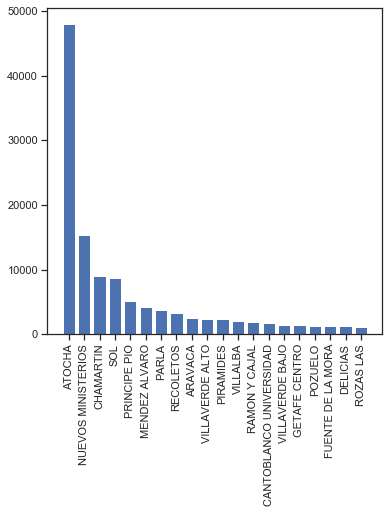

In [117]:
# Plot of absolute numbers
ranking_station_names = [s.get_name() for s in ranking_stations[0:top]]
ranking_station_values = [s.get_n_infections() for s in ranking_stations[0:top]]

fig = plt.figure(figsize=(6, 6))
plt.bar(ranking_station_names, ranking_station_values)
plt.xticks(ranking_station_names, rotation='vertical')
plt.show()
plt.close(fig)

Furthermore, we can see that the infections happen mostly at specific times: peak hours.

In [34]:
def plot_infections_timeline(station_name=None, custom_time_window=None):
    if station_name is None:
        # Whole network
        title = 'Whole network'
        time_window = '15Min' if custom_time_window is None else custom_time_window
        time_infections = []
        for name, s in stations.items():
            time_infections = time_infections + s.get_time_infections()
    else:
        title = '%s Station' % station_name.title()
        time_window = '1H' if custom_time_window is None else custom_time_window
        time_infections = network.get_stations()[station_name].get_time_infections()
            
    # Use Pandas as it is easier to group by time interval
    df = pd.DataFrame(time_infections, columns=['Time'])
    df['Value'] = 1
    df = df.append(pd.Series({'Time': '00:00:00', 'Value': 0}), ignore_index=True) # Add to force to start at 0:00h
    df = df.groupby('Time').sum()
    df.index = pd.to_timedelta(df.index.astype(str))
    df = df.resample(time_window, base=0).sum()

    # Function to format TimeDelta objects
    def strfdelta(tdelta, fmt):
        d = {'days': tdelta.days}
        d['hours'], rem = divmod(tdelta.seconds, 3600)
        d['minutes'], d['seconds'] = divmod(rem, 60)
        d['minutes'] = d['minutes'] if d['minutes'] >= 10 else '0%d' % d['minutes']
        return fmt.format(**d)

    x_labels = [strfdelta(t, '{hours}:{minutes}h') for t in df.index]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(title)
    plt.plot(x_labels, df['Value'], label='Infections')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    ax.xaxis.set_major_locator(plt.MaxNLocator(24))
    plt.show()
    plt.close(fig)

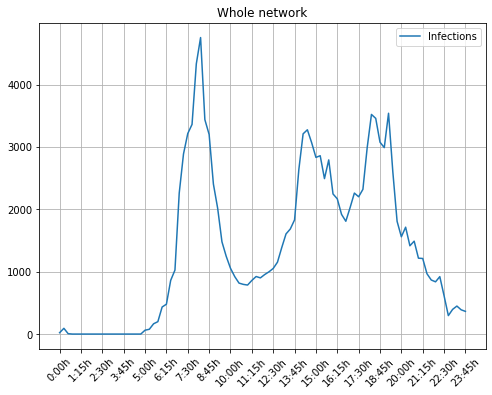

In [26]:
# Plot infections in the whole network
plot_infections_timeline()

If we analyze the number of infections per station, we observe that the peak of infections happen at a different time.

Here we have two examples:
- The first station (Fuenlabrada Station) which is in a suburb.
- The second station (Atocha Station) which is a central hub.

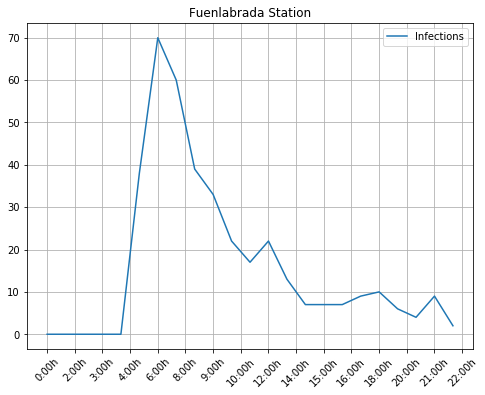

In [35]:
station_name = 'FUENLABRADA'
plot_infections_timeline(station_name)

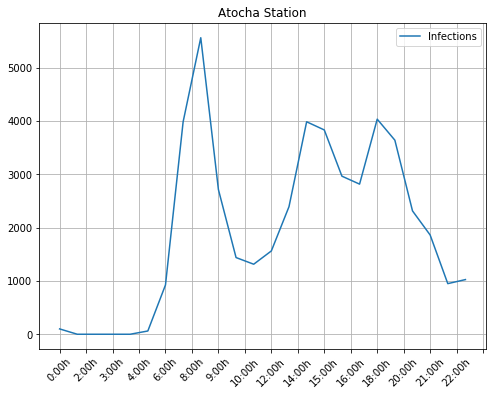

In [36]:
station_name = 'ATOCHA'
plot_infections_timeline(station_name)